In [1]:
# RMIT University in Vietnam
# Course: EEET2574 Big Data in Engineering
# Semester: 2020B
# Assessment: Big Data Project

# Authors:
#   Nguyen Minh Trang (s3751450)
#   Nguyen Manh Triet
#   Nguyen Minh Tri
#   Vang Huynh Minh Tri

# Date: 27/09/2020

In [2]:
# Install packages
# NOTE: Need graphviz installed on computer
# Best is download from their website and add Graphviz/bin to PATH
!pip install graphviz
!pip install mord

In [3]:
# Standard libraries
import numpy as np
import pandas as pd

# Helpers
from collections import Counter
from numpy import mean
from numpy import std

# Regular graphs
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerBase
from matplotlib.text import Text
import seaborn as sns
sns.set_style("whitegrid")

# Pre-train + Tuning
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import GridSearchCV

# Metrics
from sklearn import linear_model, metrics, preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score

# Models
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier

# Model viz
from sklearn.tree import export_graphviz
from sklearn import tree
from io import StringIO
from IPython.display import Image  
import pydotplus

# Mord (ordinal regression)
import mord

In [4]:
# Suppress warning
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# Data Preparation

## Aggregation (ACCIDENT, PERSON, VEHICLE)

In [5]:
# Load files
accidents = pd.read_csv('../data/CRASHES/FARS2018NationalCSV/ACCIDENT.csv')
vehicles = pd.read_csv('../data/CRASHES/FARS2018NationalCSV/VEHICLE.csv')
persons = pd.read_csv('../data/CRASHES/FARS2018NationalCSV/PERSON.csv')

print(accidents.shape)
print(vehicles.shape)
print(persons.shape)

C:\Users\mines\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (36,37,104) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(33654, 52)
(51872, 107)
(83626, 62)


In [6]:
# Merge ACCIDENT and VEHICLE by ST_CASE
# VEHICLE is trimmed to prevent duplicate columns
cols_to_use = vehicles.columns.difference(accidents.columns)
df = pd.merge(accidents,
              vehicles[cols_to_use.insert(0, 'ST_CASE')],
              how='inner',
              on='ST_CASE')

In [7]:
# Merge df and PERSON by ST_CASE
# PERSON is trimmed to prevent duplicate columns
cols_to_use = persons.columns.difference(df.columns)
df = pd.merge(df,
              persons[cols_to_use.insert(0, 'ST_CASE')],
              how='inner',
              on='ST_CASE')

In [8]:
# Drop duplicates and check for NaNs
df = df.drop_duplicates()
print(df.isna().sum().sum())
df

108283


,STATE,ST_CASE,VE_TOTAL,VE_FORMS,PVH_INVL,PEDS,PERNOTMVIT,PERMVIT,PERSONS,COUNTY,...,P_SF1,P_SF2,P_SF3,RACE,REST_MIS,REST_USE,SEAT_POS,SEX,STR_VEH,WORK_INJ
0,1,10001,2,1,1,0,0,1,1,121,...,0,0,0,2,0,20,11,1,0,1
1,1,10002,1,1,0,0,0,2,2,127,...,0,0,0,2,0,20,11,1,0,0
2,1,10002,1,1,0,0,0,2,2,127,...,0,0,0,2,0,3,13,1,0,0
3,1,10003,2,2,0,0,0,2,2,21,...,0,0,0,1,0,20,11,2,0,0
4,1,10003,2,2,0,0,0,2,2,21,...,0,0,0,0,0,20,11,1,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156630,56,560100,1,1,0,0,0,2,2,13,...,0,0,0,0,0,20,13,1,0,8
156631,56,560101,2,2,0,0,0,2,2,13,...,0,0,0,3,0,20,11,1,0,0
156632,56,560101,2,2,0,0,0,2,2,13,...,0,0,0,0,0,99,11,1,0,8
156633,56,560101,2,2,0,0,0,2,2,13,...,0,0,0,3,0,20,11,1,0,0


**Notes**
- After merging, the DataFrame has >156k rows, 188 colums, and >100k NaNs
- This is the base dimension

## Missing Values

In [9]:
# Check number of NaNs and dtype in each column
for col in df.columns:
    print(col, df[col].isna().sum(), df[col].dtype)

STATE 0 int64
ST_CASE 0 int64
VE_TOTAL 0 int64
VE_FORMS 0 int64
PVH_INVL 0 int64
PEDS 0 int64
PERNOTMVIT 0 int64
PERMVIT 0 int64
PERSONS 0 int64
COUNTY 0 int64
CITY 0 int64
DAY 0 int64
MONTH 0 int64
YEAR 0 int64
DAY_WEEK 0 int64
HOUR 0 int64
MINUTE 0 int64
NHS 0 int64
RUR_URB 0 int64
FUNC_SYS 0 int64
RD_OWNER 0 int64
ROUTE 0 int64
TWAY_ID 0 object
TWAY_ID2 105338 object
MILEPT 0 int64
LATITUDE 0 float64
LONGITUD 0 float64
SP_JUR 0 int64
HARM_EV 0 int64
MAN_COLL 0 int64
RELJCT1 0 int64
RELJCT2 0 int64
TYP_INT 0 int64
WRK_ZONE 0 int64
REL_ROAD 0 int64
LGT_COND 0 int64
WEATHER1 0 int64
WEATHER2 0 int64
WEATHER 0 int64
SCH_BUS 0 int64
RAIL 0 object
NOT_HOUR 0 int64
NOT_MIN 0 int64
ARR_HOUR 0 int64
ARR_MIN 0 int64
HOSP_HR 0 int64
HOSP_MN 0 int64
CF1 0 int64
CF2 0 int64
CF3 0 int64
FATALS 0 int64
DRUNK_DR 0 int64
ACC_TYPE 0 int64
BODY_TYP 0 int64
BUS_USE 0 int64
CARGO_BT 0 int64
CDL_STAT 0 int64
DEATHS 0 int64
DEFORMED 0 int64
DR_DRINK 0 int64
DR_HGT 0 int64
DR_PRES 0 int64
DR_SF1 0 int64
DR

In [10]:
# Drop NaNs & objects
df.drop(columns=[
    'TWAY_ID', 'TWAY_ID2', 'TRLR1VIN', 'TRLR2VIN', 'TRLR3VIN', 'VIN', 'VIN_1',
    'VIN_10', 'VIN_11', 'VIN_12', 'VIN_2', 'VIN_3', 'VIN_4', 'VIN_5', 'VIN_6',
    'VIN_7', 'VIN_8', 'VIN_9', 'RAIL', 'MCARR_I2', 'MCARR_I1', 'MCARR_ID'
],
        inplace=True)

In [11]:
# Check if there are objects left
df.loc[:, df.dtypes == object].columns

Index([], dtype='object')

In [12]:
print(df.shape)
print("Missing values:", df.isna().sum().sum())

(156190, 166)
Missing values: 0


**Notes**
- After cleaning NaNs, data is 156190 rows, 166 columns
- This is too many, need to narrow down scope

## Feature Creation

### Base severity profile

In [13]:
# Add custom legend for clarity
class TextHandler(HandlerBase):
    def create_artists(self, legend, tup, xdescent, ydescent, width, height,
                       fontsize, trans):
        tx = Text(width / 2,
                  height / 2,
                  tup[0],
                  fontsize=fontsize,
                  fontweight='bold',
                  ha='center',
                  va='center',
                  color=tup[1])
        return [tx]

Text(0.5, 1.0, 'Frequency of Injury Severity Levels')

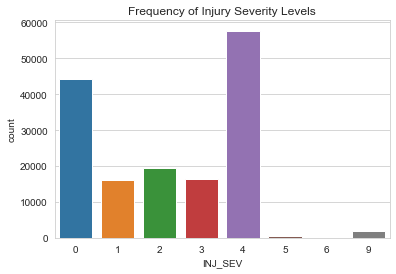

In [14]:
# Plot severity profile
ax = sns.countplot(x='INJ_SEV', data=df)
ax.set_title("Frequency of Injury Severity Levels")

In [15]:
counter = Counter(df['INJ_SEV'].sort_values())
for element, count in counter.items():
    print("Class", element, count, "{0:.0%}".format(count / len(df)))

Class 0 44137 28%
Class 1 16014 10%
Class 2 19409 12%
Class 3 16464 11%
Class 4 57708 37%
Class 5 556 0%
Class 6 3 0%
Class 9 1899 1%


**Notes**
- Most people either suffer no injury or die
- Distribution of in-between levels of injury is quite equal

*Scope*

- Since all documented crashes must result in 1+ fatalities, it is not appropriate to analyze crash factors that determine life/death
- Instead, the scope of analysis will be narrowed down to fatality-only
- All fatalities are treated equal, so a new in-depth INJ_SEV will be devised

In [16]:
# Select only entries with known dead day, hour and minute
# Known death day guarantees known dead month. Year is known as 2018
# Lower accuracy (known hour) only adds 6 more entries
df = df[(df['DEATH_DA'] != 99) & (df['DEATH_DA'] != 88) &
        (df['DEATH_HR'] != 99) & (df['DEATH_HR'] != 88) &
        (df['DEATH_MN'] != 99) & (df['DEATH_MN'] != 88)]

print(df.shape)

(53754, 166)


In [17]:
# Select only entries with known crash day, month, hour and minute
# Year is known as 2018, day and month already cleaned
df = df[(df['HOUR'] != 99) & (df['MINUTE'] != 99)]

print(df.shape)

(53596, 166)


### Prepate DEATH_DT (datetime of death) column

In [18]:
# Concatenate datetime columns to a single column (minute accuracy)
df['DEATH_DT'] = pd.to_datetime(
    df[['DEATH_DA', 'DEATH_MO', 'DEATH_YR', 'DEATH_HR',
        'DEATH_MN']].astype(str).apply(' '.join, 1),
    format='%d %m %Y %H %M')

### Prepare CRASH_DT (datetime of crash) column

In [19]:
df['CRASH_DT'] = pd.to_datetime(df[['DAY', 'MONTH', 'YEAR', 'HOUR',
                                    'MINUTE']].astype(str).apply(' '.join, 1),
                                format='%d %m %Y %H %M')

### Prepare DEATH_DELAY (time from crash to death) column

In [20]:
# DEATH_DELAY has minute-level accuracy
td = (df['DEATH_DT'] - df['CRASH_DT'])
df['DEATH_DELAY'] = (td / np.timedelta64(1, 'm')).astype('int64')

# Verify the longest time (days) until death
print(df['DEATH_DELAY'].max() / (60 * 24))

29.946527777777778


### Prepare new INJ_SEV (injury severity) column

In [21]:
# Replace old severity
df.drop(columns='INJ_SEV', inplace=True)

# New column follows custom system:
# Categorize injury severity by minutes until death
# The first few hours are critical, so smaller ranges
# System is tweaked many times to achieve best J-shaped distribution while maintaining details

df['INJ_SEV'] = pd.cut(x=df['DEATH_DELAY'],
                       bins=[-1, 0, 30, 180, 1440, 10080, 43200],
                       labels=[9, 8, 7, 6, 5, 4])
df['INJ_SEV'].dtype

CategoricalDtype(categories=[9, 8, 7, 6, 5, 4], ordered=True)

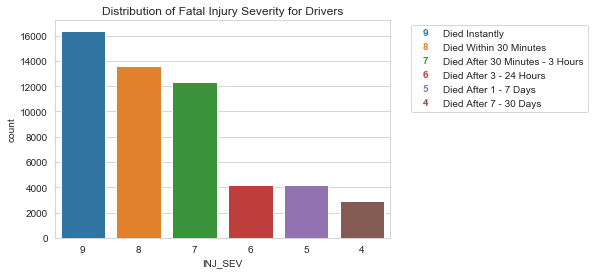

In [22]:
# Plot new severity profile
ax = sns.countplot(x='INJ_SEV', data=df)
ax.set_title("Distribution of Fatal Injury Severity for Drivers")

xticks = ax.get_xticklabels()
handles = [(handle.get_text(), color.get_fc())
           for handle, color in zip(xticks, ax.patches)]

labels = [
    'Died Instantly', 'Died Within 30 Minutes',
    'Died After 30 Minutes - 3 Hours', 'Died After 3 - 24 Hours',
    'Died After 1 - 7 Days', 'Died After 7 - 30 Days'
]

ax.legend(handles,
          labels,
          handler_map={tuple: TextHandler()},
          bbox_to_anchor=(1.05, 1),
          loc='upper left')

In [23]:
# Frequency of severity classes
counter = Counter(df['INJ_SEV'].sort_values())
for element, count in counter.items():
    print("Class", element, count, "{0:.0%}".format(count / len(df)))

Class 9 16395 31%
Class 8 13621 25%
Class 7 12310 23%
Class 6 4211 8%
Class 5 4144 8%
Class 4 2915 5%


**Notes**
- Most fatal cases died within the first 3 hours
- Past the 3-hour threshold, each class stays in much longer time
- Distribution is imbalanced, with Class 9 being the dominant class

In [24]:
# Drop component columns
# All death time columns must be deleted
# Year is 2018
# Minute is too specific
df.drop(columns=[
    'DEATH_DA', 'DEATH_MO', 'DEATH_YR', 'DEATH_HR', 'DEATH_MN', 'DEATH_TM',
    'DEATH_DT', 'CRASH_DT', 'DEATH_DELAY', 'YEAR', 'MINUTE', 'LAG_HRS',
    'LAG_MINS'
],
        inplace=True)

In [25]:
# Current dimensions
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
df

,STATE,ST_CASE,VE_TOTAL,VE_FORMS,PVH_INVL,PEDS,PERNOTMVIT,PERMVIT,PERSONS,COUNTY,...,P_SF2,P_SF3,RACE,REST_MIS,REST_USE,SEAT_POS,SEX,STR_VEH,WORK_INJ,INJ_SEV
0,1,10001,2,1,1,0,0,1,1,121,...,0,0,2,0,20,11,1,0,1,9
1,1,10002,1,1,0,0,0,2,2,127,...,0,0,2,0,20,11,1,0,0,9
2,1,10002,1,1,0,0,0,2,2,127,...,0,0,2,0,3,13,1,0,0,9
3,1,10003,2,2,0,0,0,2,2,21,...,0,0,1,0,20,11,2,0,0,9
4,1,10003,2,2,0,0,0,2,2,21,...,0,0,1,0,20,11,2,0,0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53591,56,560098,2,2,0,0,0,2,2,27,...,0,0,1,0,3,11,1,0,0,6
53592,56,560099,1,1,0,0,0,1,1,1,...,0,0,2,0,20,11,1,0,0,8
53593,56,560100,1,1,0,0,0,2,2,13,...,0,0,3,0,20,11,2,0,0,7
53594,56,560101,2,2,0,0,0,2,2,13,...,0,0,3,0,20,11,1,0,0,8


# Modeling #1

## Baseline Model
- Use K-fold cross-validation to evaluate models
- We can expect an accuracy of ~31% for the baseline model, which is the percentage of Majority class 9

In [26]:
# Evaluate a model
def evaluate_model(X, y, model):
    # Define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    # Evaluate model
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

In [27]:
# Select train and test data
X = df.drop(columns=['ST_CASE', 'INJ_SEV'])
y = df.INJ_SEV

In [28]:
# Summarize the loaded dataset
print(X.shape, y.shape, Counter(y))
# Define the reference model
model = DummyClassifier(strategy='most_frequent')
# Evaluate the model
scores = evaluate_model(X, y, model)
# Summarize performance
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

(53596, 154) (53596,) Counter({9: 16395, 8: 13621, 7: 12310, 6: 4211, 5: 4144, 4: 2915})
Mean Accuracy: 0.306 (0.000)


## Model Suite (Sample)

In [29]:
# Long wait
def get_models():
    models, names = list(), list()
    # SVM
    models.append(SVC(gamma='auto'))
    names.append('SVM')
    # KNN
    models.append(KNeighborsClassifier())
    names.append('KNN')
    # DT
    models.append(DecisionTreeClassifier(random_state=99))
    names.append('DT')
    # Bagging
    models.append(BaggingClassifier(n_estimators=100))
    names.append('BAG')
    # RF
    models.append(RandomForestClassifier(n_estimators=100))
    names.append('RF')
    # ET
    models.append(ExtraTreesClassifier(n_estimators=100))
    names.append('ET')
    return models, names

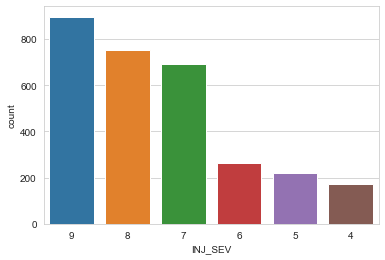

In [30]:
# Pick a random sample of 3000 entries
# This is to reduce cross validation time
sample = df.drop(columns=['ST_CASE']).sample(3000)

# Check if sample is representative
sns.countplot(sample['INJ_SEV'])

In [31]:
# Frequency of severity classes
counter = Counter(sample['INJ_SEV'].sort_values())
for element, count in counter.items():
    print("Class", element, count, "{0:.0%}".format(count / len(sample)))

Class 9 897 30%
Class 8 753 25%
Class 7 694 23%
Class 6 265 9%
Class 5 219 7%
Class 4 172 6%


**Notes**
- Judging from class distribution, the sample is quite representative

In [32]:
# Pick train and test data
X = sample.drop(columns=['INJ_SEV'])
y = sample.INJ_SEV

>SVM 0.300 (0.002)
>KNN 0.301 (0.015)
>DT 0.486 (0.023)
>BAG 0.586 (0.017)
>RF 0.583 (0.016)
>ET 0.570 (0.014)


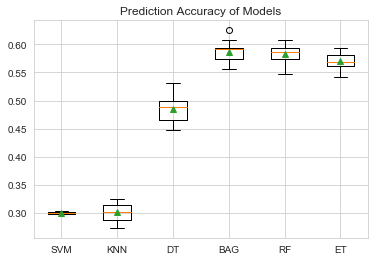

In [33]:
# Define models
models, names = get_models()
results = list()

# Evaluate each model
for i in range(len(models)):
    # Evaluate the model and store results
    scores = evaluate_model(X, y, models[i])
    results.append(scores)
    # Summarize performance
    print('>%s %.3f (%.3f)' % (names[i], mean(scores), std(scores)))

# Plot the results
plt.boxplot(results, labels=names, showmeans=True)
plt.title("Prediction Accuracy of Models")
plt.show()

**Notes**
- Result may vary with each run
- For the sake of rules, let's focus on DT
- DT achieves 47% accuracy with (3000, 154) and (3000,) random sample

## Decision Tree

In [34]:
# Select train and test data
X = df.drop(columns=['ST_CASE', 'INJ_SEV'])
y = df.INJ_SEV
print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y)

(53596, 154) (53596,)


In [35]:
feature_names = X.columns.values
target_names = ['4', '5', '6', '7', '8', '9']

In [36]:
# Fitting Decision Tree (no limit)
clf = DecisionTreeClassifier(random_state=99)
clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=99, splitter='best')

In [37]:
# Check result
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           4       0.50      0.47      0.49       750
           5       0.45      0.46      0.45       996
           6       0.46      0.45      0.46      1086
           7       0.67      0.67      0.67      3105
           8       0.68      0.67      0.67      3407
           9       0.79      0.81      0.80      4055

    accuracy                           0.67     13399
   macro avg       0.59      0.59      0.59     13399
weighted avg       0.66      0.67      0.66     13399



**Notes**
- On full dataset with 154 training attributes and no depth limit, accuracy is 66%

# Dimensionality Reduction #1 (Data Preparation 2)
- Perform dimensionality reduction to see if performance changes
- Last: (53596, 154) (53596,)

## Driver-only

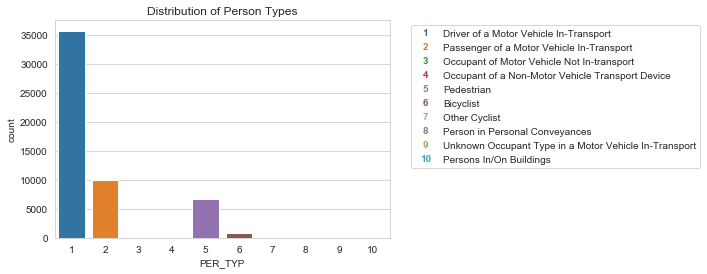

In [38]:
# Plot person type profile
ax = sns.countplot(x='PER_TYP', data=df)
ax.set_title("Distribution of Person Types")

xticks = ax.get_xticklabels()
handles = [(handle.get_text(), color.get_fc())
           for handle, color in zip(xticks, ax.patches)]

labels = [
    'Driver of a Motor Vehicle In-Transport',
    'Passenger of a Motor Vehicle In-Transport',
    'Occupant of Motor Vehicle Not In-transport',
    'Occupant of a Non-Motor Vehicle Transport Device', 'Pedestrian',
    'Bicyclist', 'Other Cyclist', 'Person in Personal Conveyances',
    'Unknown Occupant Type in a Motor Vehicle In-Transport',
    'Persons In/On Buildings'
]

ax.legend(handles,
          labels,
          handler_map={tuple: TextHandler()},
          bbox_to_anchor=(1.05, 1),
          loc='upper left')

In [39]:
# Frequency of person classes
counter = Counter(df['PER_TYP'].sort_values())
for element, count in counter.items():
    print("Class", element, count, "{0:.0%}".format(count / len(df)))

Class 1 35738 67%
Class 2 10047 19%
Class 3 49 0%
Class 4 15 0%
Class 5 6687 12%
Class 6 855 2%
Class 7 3 0%
Class 8 141 0%
Class 9 55 0%
Class 10 6 0%


**Notes**
- Majority of deaths are drivers (67%)
- Next are passengers (19%) and pedestrians (12%)
- All other classes are trivial

*Scope*

- Scope can be further narrowed down to driver-only, for drivers will benefit most from this analysis

In [40]:
# Driver only
df = df.loc[df['PER_TYP'] == 1]

**Notes**
- Select features based on scope, which so far covers:

        - Drivers of in-transport motor vehicles
        - Driver fatalities
        
- Thus, aspects like seat position, number of drivers, non-drivers, non-motorists etc. will be dropped
- ID numbers (st_case, traffic way ID, plate number etc.) except ST_CASE will also be removed

In [41]:
# Drop out of scope columns
print("Old shape:", df.shape)

df.drop(
    columns=[
        'MILEPT',
        'MAK_MOD',  # IDs
        'PEDS',
        'PERNOTMVIT',
        'PVH_INVL',
        'PERSONS',
        'PERMVIT',  # Involve persons/vehicles not in-transport
        'UNITTYPE',
        'HIT_RUN',
        'TOWED',
        'STR_VEH',  # In-transport vehicles only
        'VE_TOTAL',
        'DR_PRES',
        'SEAT_POS',
        'PER_TYP',  # Drivers only
        'COUNTY',
        'CITY',
        'DR_ZIP',
        'CF1',
        'CF2',
        'CF3'
    ],
    inplace=True)

print("New shape:", df.shape)

Old shape: (35738, 156)
New shape: (35738, 135)


## Irrelevant attributes

**Notes**
- The next step is to drop columns that are irrelevant or too specific
- For example, information of drug/alcohol testing procedures, driver license, and past violations is too specific
- Ownership of the road or its special jurisdiction are irrelevant
- Road design (interstate, local) and land use (rural, urban) however, are kept
- Columns only apply to special scenarios (intersection/junction, jack-knife crashes) are also removed
- Columns that show number of deaths are removed, since they don't contribute to causes of accident/injury
- Columns of duplicate functions (i.e. P_SF to DR_SF, racial details etc.) are removed

In [42]:
# Drop irrelevant columns
print("Old shape:", df.shape)

df.drop(columns=[
    'NHS', 'RD_OWNER', 'ROUTE', 'SP_JUR', 'RELJCT1', 'RELJCT2', 'J_KNIFE',
    'FIRE_EXP', 'ROLINLOC', 'ROLLOVER', 'UNDERIDE', 'TYP_INT', 'FATALS',
    'DRUNK_DR', 'DEATHS', 'DOA', 'DRINKING', 'FIRST_MO', 'FIRST_YR', 'LAST_MO',
    'LAST_YR', 'L_COMPL', 'L_ENDORS', 'L_RESTRI', 'L_STATE', 'PREV_ACC',
    'PREV_DWI', 'PREV_OTH', 'PREV_SPD', 'PREV_SUS1', 'PREV_SUS2', 'PREV_SUS3',
    'L_STATUS', 'L_TYPE', 'OWNER', 'REG_STAT', 'MODEL', 'GVWR', 'BODY_TYP',
    'MAKE', 'VEH_NO', 'M_HARM', 'ALC_DET', 'ALC_RES', 'ALC_STATUS', 'ATST_TYP',
    'DRUG_DET', 'DSTATUS', 'EJECTION', 'EJ_PATH', 'EXTRICAT', 'LOCATION',
    'VNUM_LAN', 'VTRAFWAY', 'VALIGN', 'PCRASH4', 'PCRASH5', 'PER_NO', 'P_SF1',
    'P_SF2', 'P_SF3', 'HISPANIC'
],
        inplace=True)

print("New shape:", df.shape)

Old shape: (35738, 135)
New shape: (35738, 73)


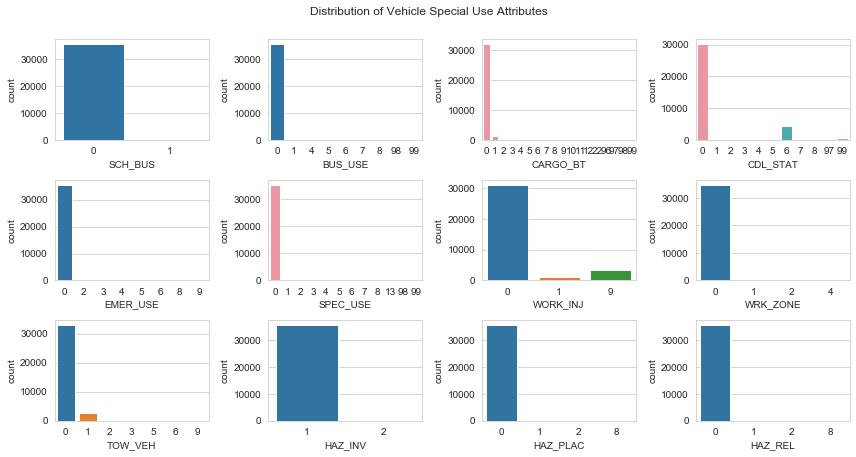

In [43]:
# Plot distribution of columns that relate to special use/commercial vehicles
special_veh_cols = [
    'SCH_BUS', 'BUS_USE', 'CARGO_BT', 'CDL_STAT', 'EMER_USE', 'SPEC_USE',
    'WORK_INJ', 'WRK_ZONE', 'TOW_VEH', 'HAZ_INV', 'HAZ_PLAC', 'HAZ_REL'
]
fig, axes = plt.subplots(3, 4, figsize=(12, 6))

i = 0
j = 0
for col in special_veh_cols:
    # Create countplot in grid
    sns.countplot(df[col], ax=axes[i, j])
    j += 1  # Increment column
    if (j >= 4):  # If past last column
        j = 0  # Reset column
        i += 1  # Next row

plt.suptitle("Distribution of Vehicle Special Use Attributes", y=1.05)
plt.tight_layout()

**Notes**
- Not applicable entries are usually marked with 0
- The vast majority of vehicles are civilian, not engaging in commercial/work
- Also, there are systemic differences between driver behaviors when at work vs. driving casually
- Thus, scope can be narrowed down to casual rides only

In [44]:
# Drop all special/commercial use columns
print("Old shape:", df.shape)
df.drop(columns=special_veh_cols + ['HAZ_CNO', 'HAZ_ID'], inplace=True)
print("New shape:", df.shape)

Old shape: (35738, 73)
New shape: (35738, 59)


In [45]:
# We then attempt to concatenate columns relating to hospitalized time
# How many entries have known hospitalized hour and minute?
detailed_hosp_time = df[(0 <= df['HOSP_HR']) & (df['HOSP_HR'] <= 23) &
                        (0 <= df['HOSP_MN']) & (df['HOSP_MN'] <= 59)]
print("Percentage of entries with known hospitalized hour and minute:",
      detailed_hosp_time.shape[0] / df.shape[0] * 100)

Percentage of entries with known hospitalized hour and minute: 26.179416867200178


In [46]:
# Less than 30% of entries have detailed hospitalized time, so related columns are dropped
print("Old shape:", df.shape)

df.drop(columns=[
    'NOT_HOUR', 'NOT_MIN', 'ARR_HOUR', 'ARR_MIN', 'HOSP_HR', 'HOSP_MN'
],
        inplace=True)

print("New shape:", df.shape)

Old shape: (35738, 59)
New shape: (35738, 53)


## Feature Selection (Categorical, Chi2 Test)
- This section evaluates categorical attributes by correlation to injury severity
- Let's check performance after removing attributes

In [47]:
# First, check number of attributes
print(len(df.columns.values))
df.columns.values

53


array(['STATE', 'ST_CASE', 'VE_FORMS', 'DAY', 'MONTH', 'DAY_WEEK', 'HOUR',
       'RUR_URB', 'FUNC_SYS', 'LATITUDE', 'LONGITUD', 'HARM_EV',
       'MAN_COLL', 'REL_ROAD', 'LGT_COND', 'WEATHER1', 'WEATHER2',
       'WEATHER', 'ACC_TYPE', 'DEFORMED', 'DR_DRINK', 'DR_HGT', 'DR_SF1',
       'DR_SF2', 'DR_SF3', 'DR_SF4', 'DR_WGT', 'IMPACT1', 'MOD_YEAR',
       'NUMOCCS', 'P_CRASH1', 'P_CRASH2', 'P_CRASH3', 'SPEEDREL',
       'TRAV_SP', 'VEH_SC1', 'VEH_SC2', 'VPAVETYP', 'VPROFILE',
       'VSPD_LIM', 'VSURCOND', 'VTCONT_F', 'VTRAFCON', 'V_CONFIG', 'AGE',
       'AIR_BAG', 'DRUGS', 'HOSPITAL', 'RACE', 'REST_MIS', 'REST_USE',
       'SEX', 'INJ_SEV'], dtype=object)

In [48]:
# Next, split attributes into Categorical and Numerical for processing
# Some attributes, like ST_CASE and INJ_SEV don't need to be processed
num = [
    'VE_FORMS', 'LATITUDE', 'LONGITUD', 'DR_HGT', 'DR_WGT', 'AGE', 'MOD_YEAR',
    'NUMOCCS', 'TRAV_SP', 'VSPD_LIM'
]

print("Number of Numerical attributes:", len(num))

cat = df.drop(columns=['ST_CASE', 'INJ_SEV']).columns.difference(num,
                                                                 sort=False)
print("Number of Categorical attributes:", len(cat))
cat

Number of Numerical attributes: 10
Number of Categorical attributes: 41


Index(['STATE', 'DAY', 'MONTH', 'DAY_WEEK', 'HOUR', 'RUR_URB', 'FUNC_SYS',
       'HARM_EV', 'MAN_COLL', 'REL_ROAD', 'LGT_COND', 'WEATHER1', 'WEATHER2',
       'WEATHER', 'ACC_TYPE', 'DEFORMED', 'DR_DRINK', 'DR_SF1', 'DR_SF2',
       'DR_SF3', 'DR_SF4', 'IMPACT1', 'P_CRASH1', 'P_CRASH2', 'P_CRASH3',
       'SPEEDREL', 'VEH_SC1', 'VEH_SC2', 'VPAVETYP', 'VPROFILE', 'VSURCOND',
       'VTCONT_F', 'VTRAFCON', 'V_CONFIG', 'AIR_BAG', 'DRUGS', 'HOSPITAL',
       'RACE', 'REST_MIS', 'REST_USE', 'SEX'],
      dtype='object')

In [49]:
# Rank categorical variables by chi2 score
X = df[cat]
y = df.INJ_SEV
print(X.shape)
print(y.shape)

# Build model
selector = SelectKBest(chi2, k='all')
selector.fit(X, y)

# List of features with chi2 scores
d = {
    'FEATURE': X.columns,
    'CHI2_SCORE': selector.scores_,
    'P_VALUE': selector.pvalues_
}
chi_features = pd.DataFrame(d)
chi_features_sorted = chi_features.sort_values(by=['CHI2_SCORE', 'P_VALUE'],
                                               ascending=True)
chi_features_sorted.reset_index(drop=True, inplace=True)
chi_features_sorted

(35738, 41)
(35738,)


,FEATURE,CHI2_SCORE,P_VALUE
0,SEX,2.997092,7.004342e-01
1,REST_MIS,4.687665,4.551735e-01
2,DAY_WEEK,8.046950,1.536671e-01
3,DEFORMED,13.864742,1.649181e-02
4,MONTH,17.910612,3.060544e-03
5,DAY,65.253925,9.927232e-13
6,P_CRASH1,67.713446,3.062940e-13
7,LGT_COND,101.040345,3.189764e-20
8,VPROFILE,101.494688,2.558379e-20
9,VTRAFCON,162.066152,3.590489e-33


**Notes**
- From the Chi2 test, hospital transportation and weather info are best predictors

In [50]:
# Take 25 best categorical features
cat = chi_features_sorted['FEATURE'].head(25).tolist()

In [51]:
cat

['SEX',
 'REST_MIS',
 'DAY_WEEK',
 'DEFORMED',
 'MONTH',
 'DAY',
 'P_CRASH1',
 'LGT_COND',
 'VPROFILE',
 'VTRAFCON',
 'VSURCOND',
 'REL_ROAD',
 'DR_DRINK',
 'VEH_SC1',
 'SPEEDREL',
 'RUR_URB',
 'DR_SF1',
 'MAN_COLL',
 'HARM_EV',
 'HOUR',
 'VTCONT_F',
 'WEATHER2',
 'IMPACT1',
 'DR_SF3',
 'VEH_SC2']

In [52]:
# Drop 16 features
drop_cat = chi_features_sorted['FEATURE'].tail(16).tolist()
df.drop(columns=drop_cat, inplace=True)

## Feature Selection (Numerical)
- Remove unknowns from numerical variables

In [53]:
# Cast all columns to int except LAT and LONG
cols = df.drop(columns=['LATITUDE', 'LONGITUD']).columns.values
df[cols] = df[cols].astype('int64')

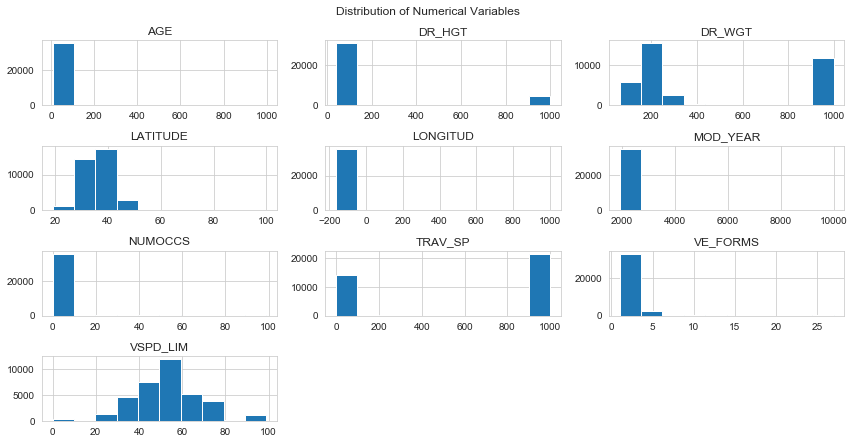

In [54]:
# Histograms show outliers (9, 99 etc.) which are marked unknowns
df[num].hist(figsize=(12, 6))
plt.suptitle("Distribution of Numerical Variables", x=0.5, y=1.02, ha='center')
plt.tight_layout()

In [55]:
# TRAV_SP has many outliers, let's see if they are unknowns
df.loc[df['TRAV_SP'].isin({998, 999}), 'TRAV_SP']

11       999
16       999
44       999
45       999
56       999
        ... 
53555    999
53569    999
53586    999
53591    999
53594    999
Name: TRAV_SP, Length: 21427, dtype: int64

In [56]:
# Drop attribute due to many missing values (18k+)
df.drop(columns=['TRAV_SP'], inplace=True)
num.remove('TRAV_SP')

In [57]:
# Function to drop all rows where a column contains certain values
def drop_unknown(data, col, vals):
    print("Column:", col)
    data.loc[data[col].isin(vals), col] = np.nan
    print("Number of rows dropped:", data.isna().sum().sum())
    data.dropna(inplace=True)
    print("Total number of rows:", len(df))
    print()

In [58]:
# Drop all unknowns from other columns
drop_unknown(df, 'AGE', {997, 998, 999})
drop_unknown(df, 'DR_HGT', {997, 998, 999})
drop_unknown(df, 'DR_WGT', {997, 998, 999})
drop_unknown(df, 'LATITUDE', {77.7777000, 88.8888000, 99.9999000})
drop_unknown(df, 'LONGITUD', {777.7777000, 888.8888000, 999.9999000})
drop_unknown(df, 'MOD_YEAR', {9998, 9999})
drop_unknown(df, 'NUMOCCS', {99})
drop_unknown(df, 'VSPD_LIM', {0, 98, 99})

Column: AGE
Number of rows dropped: 24
Total number of rows: 35714

Column: DR_HGT
Number of rows dropped: 4720
Total number of rows: 30994

Column: DR_WGT
Number of rows dropped: 7185
Total number of rows: 23809

Column: LATITUDE
Number of rows dropped: 55
Total number of rows: 23754

Column: LONGITUD
Number of rows dropped: 0
Total number of rows: 23754

Column: MOD_YEAR
Number of rows dropped: 139
Total number of rows: 23615

Column: NUMOCCS
Number of rows dropped: 48
Total number of rows: 23567

Column: VSPD_LIM
Number of rows dropped: 711
Total number of rows: 22856



In [59]:
# Statistics
df[num].describe()

,VE_FORMS,LATITUDE,LONGITUD,DR_HGT,DR_WGT,AGE,MOD_YEAR,NUMOCCS,VSPD_LIM
count,22856.000000,22856.000000,22856.000000,22856.000000,22856.000000,22856.000000,22856.000000,22856.000000,22856.000000
mean,2.085404,37.784642,-95.246700,68.703316,187.297515,46.211936,2006.886288,1.346736,51.468761
std,1.403020,4.520673,15.153745,3.872194,46.653584,19.549489,7.627362,0.974519,12.165622
min,1.000000,19.116831,-159.558000,40.000000,60.000000,7.000000,1928.000000,1.000000,5.000000
25%,1.000000,34.118713,-105.774250,66.000000,155.000000,29.000000,2002.000000,1.000000,45.000000
50%,2.000000,37.726746,-90.112200,69.000000,180.000000,45.000000,2007.000000,1.000000,55.000000
75%,2.000000,40.843104,-84.235525,72.000000,214.000000,61.000000,2013.000000,1.000000,55.000000
max,27.000000,69.733347,-67.015100,87.000000,515.000000,99.000000,2020.000000,55.000000,80.000000


In [60]:
# 'NUMOCCS' and 'VE_FORMS' data look skewed, let's drop them
df.drop(columns=['NUMOCCS', 'VE_FORMS'], inplace=True)
num.remove('NUMOCCS')
num.remove('VE_FORMS')

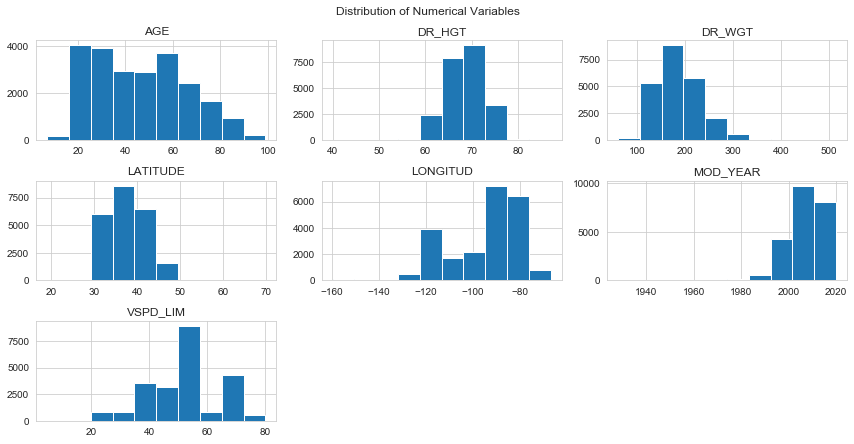

In [61]:
# Replot
df[num].hist(figsize=(12, 6))
plt.suptitle("Distribution of Numerical Variables", x=0.5, y=1.02, ha='center')
plt.tight_layout()

# Modeling #2

In [62]:
# List all current attributes
cat = list(cat)
print("Number of Categorical attributes:", len(cat))
print(cat)
print()

print("Number of Numerical attributes:", len(num))
print(num)
print()

print("Attributes not mentioned above: 'ST_CASE', 'INJ_SEV'")
print()

print("Total number of attributes:", len(df.columns.values))
print(df.columns.values)
print()

Number of Categorical attributes: 25
['SEX', 'REST_MIS', 'DAY_WEEK', 'DEFORMED', 'MONTH', 'DAY', 'P_CRASH1', 'LGT_COND', 'VPROFILE', 'VTRAFCON', 'VSURCOND', 'REL_ROAD', 'DR_DRINK', 'VEH_SC1', 'SPEEDREL', 'RUR_URB', 'DR_SF1', 'MAN_COLL', 'HARM_EV', 'HOUR', 'VTCONT_F', 'WEATHER2', 'IMPACT1', 'DR_SF3', 'VEH_SC2']

Number of Numerical attributes: 7
['LATITUDE', 'LONGITUD', 'DR_HGT', 'DR_WGT', 'AGE', 'MOD_YEAR', 'VSPD_LIM']

Attributes not mentioned above: 'ST_CASE', 'INJ_SEV'

Total number of attributes: 34
['ST_CASE' 'DAY' 'MONTH' 'DAY_WEEK' 'HOUR' 'RUR_URB' 'LATITUDE' 'LONGITUD'
 'HARM_EV' 'MAN_COLL' 'REL_ROAD' 'LGT_COND' 'WEATHER2' 'DEFORMED'
 'DR_DRINK' 'DR_HGT' 'DR_SF1' 'DR_SF3' 'DR_WGT' 'IMPACT1' 'MOD_YEAR'
 'P_CRASH1' 'SPEEDREL' 'VEH_SC1' 'VEH_SC2' 'VPROFILE' 'VSPD_LIM'
 'VSURCOND' 'VTCONT_F' 'VTRAFCON' 'AGE' 'REST_MIS' 'SEX' 'INJ_SEV']



## Model Suite (Sample)

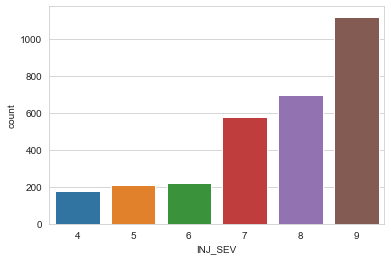

In [63]:
# Pick a random sample of 3000 entries
# This is to reduce cross validation time
sample = df.drop(columns=['ST_CASE']).sample(3000)

# Check if sample is representative
sns.countplot(sample['INJ_SEV'])

In [64]:
# Pick train and test data
X = sample.drop(columns=['INJ_SEV'])
y = sample.INJ_SEV
print(X.shape, y.shape)

(3000, 32) (3000,)


>SVM 0.372 (0.001)
>KNN 0.302 (0.018)
>DT 0.326 (0.015)
>BAG 0.436 (0.015)
>RF 0.429 (0.014)
>ET 0.417 (0.013)


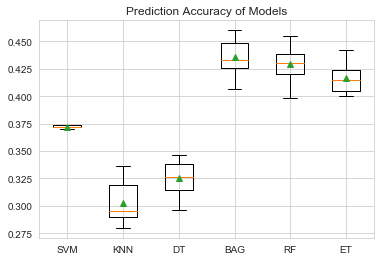

In [65]:
# Define models
models, names = get_models()
results = list()

# Evaluate each model
for i in range(len(models)):
    # Evaluate the model and store results
    scores = evaluate_model(X, y, models[i])
    results.append(scores)
    # Summarize performance
    print('>%s %.3f (%.3f)' % (names[i], mean(scores), std(scores)))

# Plot the results
plt.boxplot(results, labels=names, showmeans=True)
plt.title("Prediction Accuracy of Models")
plt.show()

**Notes**
- Result may vary with each run
- BAG, RF and ET consistently perform better than DT
- DT achieves 32% accuracy with (3000, 32) (3000,)
- Performance decreases after Reduction #1

## Decision Tree (Tuning Applied)

In [66]:
# Select train and test data
X = df.drop(columns=['ST_CASE', 'INJ_SEV'])
y = df.INJ_SEV
print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y)

(22856, 32) (22856,)


In [67]:
feature_names = X.columns.values
target_names = ['4', '5', '6', '7', '8', '9']

In [69]:
# Start tuning
param_grid = {
      'criterion' : ['gini','entropy'],
      'max_depth': [5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 100]}

# Create GridSearchCV object which uses K-Fold cross-validation to tune
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=99), param_grid, cv=10, verbose=1)
grid_search.fit(X_train, y_train)

# Print out the best parameters of classification
print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.best_estimator_)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  1.8min finished


{'criterion': 'entropy', 'max_depth': 30}
0.5236848658449877
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=30, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=99, splitter='best')


**Notes**
- Result may varies slightly with each run
- For current run, best accuracy is achieved with criterion='entropy' and max-depth=25
- Best max-depth may vary up to 40 but accuracy doesn't change much
- On reduced dataset with (32) (,), best accuracy is 66%
- This is a good tradeoff

In [70]:
# Fitting Decision Tree based on best parameters
clf = DecisionTreeClassifier(criterion='entropy', max_depth=30)
clf.fit(X_train, y_train)

# Check result
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           4       0.45      0.44      0.44       285
           5       0.35      0.35      0.35       374
           6       0.44      0.40      0.42       409
           7       0.50      0.50      0.50      1132
           8       0.57      0.59      0.58      1330
           9       0.67      0.68      0.67      2184

    accuracy                           0.57      5714
   macro avg       0.50      0.49      0.50      5714
weighted avg       0.57      0.57      0.57      5714



**Notes**
- We can expect an accuracy of 63-66% for best model on (32) (,)

In [71]:
# Function to draw confusion matrix
def draw_confusion_matrix(y_true, y_pred):
    data = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(data, columns=np.unique(y_test), index=np.unique(y_test))
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'

    plt.figure(figsize=(8, 6))
    plt.title("Confusion Matrix for Injury Severity Prediction")
    sns.set(font_scale=1.2)
    sns.heatmap(df_cm, cmap='viridis', annot=True, fmt='.0f')
    sns.set_style("whitegrid")  # Reset style

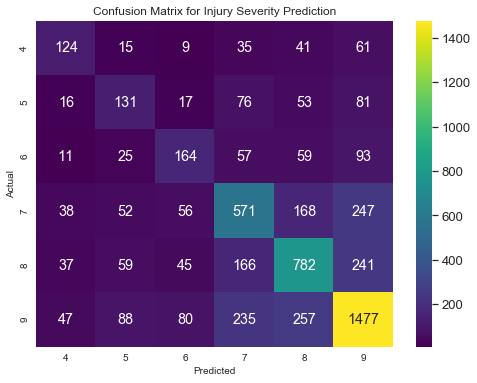

In [72]:
# Plot confusion matrix
draw_confusion_matrix(y_test, y_pred)

In [73]:
# Change max-depth to see if accuracy drops much
clf = DecisionTreeClassifier(criterion='entropy', max_depth=4)
clf.fit(X_train, y_train)

# Check result
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           4       0.24      0.21      0.22       285
           5       0.22      0.02      0.04       374
           6       1.00      0.02      0.04       409
           7       0.00      0.00      0.00      1132
           8       0.34      0.69      0.45      1330
           9       0.51      0.64      0.57      2184

    accuracy                           0.42      5714
   macro avg       0.38      0.26      0.22      5714
weighted avg       0.37      0.42      0.34      5714



C:\Users\mines\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


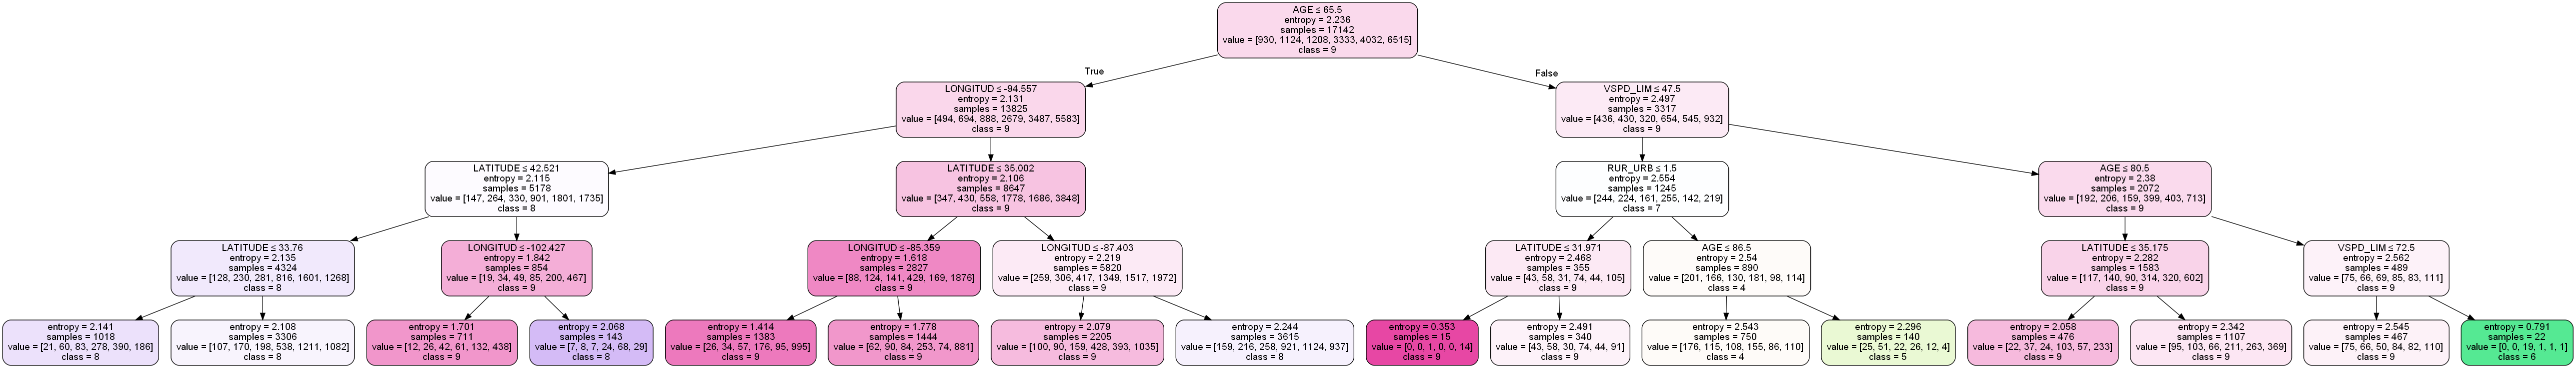

In [74]:
# Visualization (Depth=4)
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_names,class_names=target_names)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('tree.png')
Image(graph.create_png())

In [75]:
# Change max-depth to see if accuracy drops much
clf = DecisionTreeClassifier(criterion='entropy', max_depth=5)
clf.fit(X_train, y_train)

# Check result
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           4       0.23      0.15      0.19       285
           5       0.15      0.02      0.04       374
           6       0.90      0.02      0.04       409
           7       0.31      0.09      0.14      1132
           8       0.34      0.65      0.45      1330
           9       0.53      0.63      0.57      2184

    accuracy                           0.42      5714
   macro avg       0.41      0.26      0.24      5714
weighted avg       0.43      0.42      0.37      5714



**Notes**
- Depth=5 is the lowest model can go before failing to predict any class

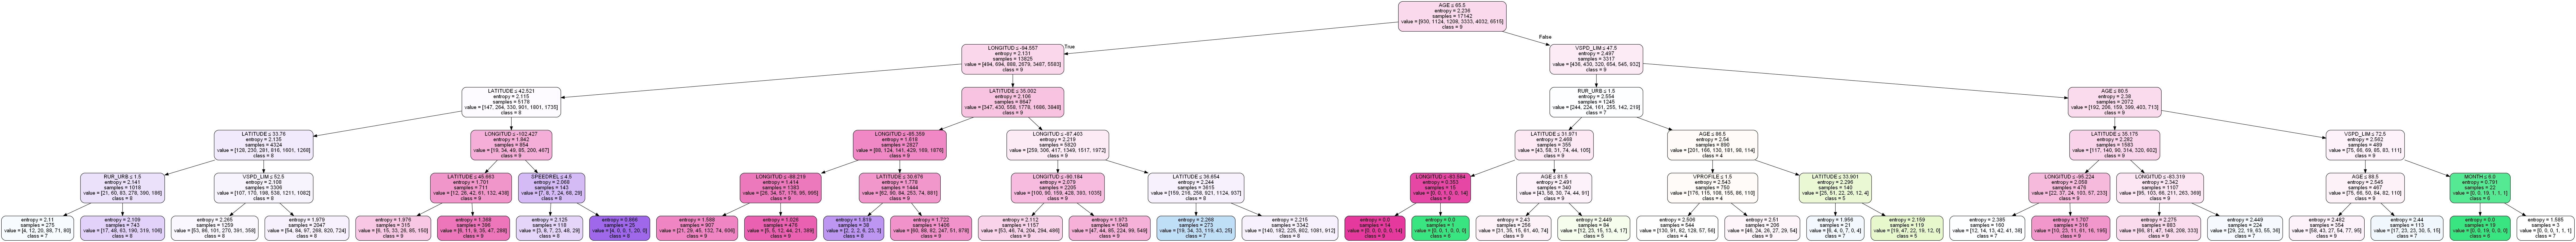

In [76]:
# Visualization (Depth=5)
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_names,class_names=target_names)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('tree.png')
Image(graph.create_png())